First Version Of SugarScape (Once the Population fails, it never recovers)

Student Names: Bobby Sokhi & Talha Ghumra 

Had to use the code 'Cell 2D' implemented by the author of this book to visualize the simulation changes.

In [12]:
import matplotlib.pyplot as plt 
import numpy as np
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
from time import sleep

from os.path import basename, exists
def download (url):
    filename = basename(url)
    if not exists (filename):
        from urllib.request import urlretrieve
        local, _ = urlretrieve(url, filename)
        print('Downloaded' + local)

download('https://github.com/AllenDowney/ThinkComplexity2/raw/master/notebooks/utils.py')
download('https://github.com/AllenDowney/ThinkComplexity2/raw/master/notebooks/Cell2D.py')

In [13]:
from utils import decorate

The following function -> "make_locs" takes in 2 parameters 'n' and 'm' and returns an array "t". For example, if n = 2 and  m = 3, then the range of n = 2 -> (0,1) and the range of m = 3 -> (0,1,2). Then i = 0 is combined with j = 0, 1, 2 with a nested for loop and the process is repeated until the ranges of both i and j are exhausted.

In [2]:
def make_locs (n,m):
    
    t = [(i , j) for  i in range(n) for j in range(m)]
    return np.array(t)

The following function -> "make_visible_locs" takes in a single paramter 'vision or the range of an agent' and returns an array where each row is the coordinate of a visible cell. For example, if vision = 2, the nested function, "make_array" will make a randomized array 'a' of the form [(-d,0),(d,0),(0,-d),(0,d)] where d has range (1,vision+1) i.e. (1,3) i.e 1,2 and then loop through these elemets until the range has been exhausted.

In [3]:
def make_visible_locs(vision):
    
    def make_array(d):
        
        a = np.array([[-d,0], [d,0], [0,-d], [0,d]])
        np.random.shuffle(a)
        return a
    
    arrays = [make_array(d) for d in range(1,vision+1)]
    return np.vstack(arrays)

The following function -> "distance_from" takes in 3 parameters 'n','i','j', and returns the distance of each cell from the given coordinates. For example, if n = 5, then X and Y will be a 5x5 matrix consisting of values -> (0,1,2,3,4). It will then return the hypotenuse of the X and Y matrix.

In [4]:
def distances_from(n, i, j):
    
    X , Y = np.indices((n,n))
    return np.hypot(X-i,Y-j)

Creating a class -> 'SugarScape' that takes in a single parameter, 'Cell2D' which is another class that has been downloaded from the author's repository.

The function -> '__init__' takes in 3 parameters, 'self','n', and '** params' respectively. The main objective of this function is to keep a track of the variables, make the capacity array (the capacity is initialized to max) and to make the agents. 

The function -> '__make_capacity__' takes a single parameter, 'self' and is responsible for constructing the capacity array. This is achieved by first computing the distance of each cell from their respective peaks and then the cells in the capacity array are set according to their distance from their respective peaks.

The function -> '__make_agents__' takes a single parameter, 'self' and is responsible for constructing the agents. This is acheived by determining where the agents start and based off of that it generates locations in X and Y coords. In the end, the function also keeps updating the amount of cells that are occupied / being occupied to avoid over population.

The function -> '__grow__' takes a single parameter, 'self' and is responsible for adding 'sugar' or 'wealth' to all the cells and keeps a track of 'oversugaring' the cells.

The function -> '__look_and_move__' takes in 3 parameters, 'self','center' and 'vision' respectively. In this context, center is the coordinates of the middle cell represented as a tuple and the vision is the maximum visible distance represented as an integer. This function is responsible for finding the visible cell with the most sugar and this is acheived by first finding all the visible cells and then converting rows of those arrays into tuples and then based off of the 3 conditions i.e. occupied, unoccupied and sugar level the function makes it's decision and moves the agents.

The function -> '__harvest__' takes in 2 parameters 'self' and 'loc' and is responsible for removing the sugar once the agent has harvested that cell and returns the coordinates of that cell as a tuple.

The function -> '__step__' takes a single parameter 'self' and is responsible for executing one step at a time throughout the simulation. In order, first it loops through all the agents in a randomized order and marks whatever cell is not occupied as unoccupied. If the agent is dead or starved it removes the agent from the cell. Then it updates the time series analysis of the simulation and finally adds in some more sugar for the next time step.

The function -> '__add_agent__' takes a single parameter 'self' and is responsible for adding new agents after every step depending on the simulation and population size.

The function -> '__random_loc__' takes a single parameter 'self' and is responsible for returning the coords in tuples for a random unoccupied cell.

The function -> '__draw__' takes a single parameter 'self' is responisble for drawing the agents in blue.

The function -> '__get_coords__' takes a single paramter 'self' and is responsible for converting the location of occupied cells from (row,col) to (x,y) represented as tuples.

In [5]:
from scipy.signal import correlate2d
from Cell2D import Cell2D, draw_array

class Sugarscape(Cell2D):
    
    def __init__(self, n, **params):
        
        self.n = n
        self.params = params
        self.agent_count_seq = []
        self.capacity = self.make_capacity()
        self.array = self.capacity.copy()
        self.make_agents()
        
    def make_capacity(self):

        dist1 = distances_from(self.n, 15, 15)
        dist2 = distances_from(self.n, 35, 35)
        dist = np.minimum(dist1, dist2)
        
        bins = [21, 16, 11, 6]
        a = np.digitize(dist, bins)
        return a
        
    def make_agents(self):
        
        n, m = self.params.get('starting_box', self.array.shape)
        locs = make_locs(n, m)
        np.random.shuffle(locs)
        
        num_agents = self.params.get('num_agents', 400)
        assert(num_agents <= len(locs))
        self.agents = [Agent(locs[i], self.params) 
                       for i in range(num_agents)]
        
        self.occupied = set(agent.loc for agent in self.agents)
            
    def grow(self):
        
        grow_rate = self.params.get('grow_rate', 1)
        self.array = np.minimum(self.array + grow_rate, self.capacity)
        
    def look_and_move(self, center, vision):
        
        locs = make_visible_locs(vision)
        locs = (locs + center) % self.n
        locs = [tuple(loc) for loc in locs]
        empty_locs = [loc for loc in locs if loc not in self.occupied]
        
        if len(empty_locs) == 0:
            return center
        
        t = [self.array[loc] for loc in empty_locs]
        i = np.argmax(t)
        return empty_locs[i]
    
    def harvest(self, loc):
    
        sugar = self.array[loc]
        self.array[loc] = 0
        return sugar
    
    def step(self):
      
        replace = self.params.get('replace', False)
        random_order = np.random.permutation(self.agents)
        for agent in random_order:
            
            self.occupied.remove(agent.loc)
            agent.step(self)

            if agent.is_starving() or agent.is_old():
                self.agents.remove(agent)
                if replace:
                    self.add_agent()
            else:
                self.occupied.add(agent.loc)

        self.agent_count_seq.append(len(self.agents))
        self.grow()
        return len(self.agents)
    
    def add_agent(self):

        new_agent = Agent(self.random_loc(), self.params)
        self.agents.append(new_agent)
        self.occupied.add(new_agent.loc)
        return new_agent
    
    def random_loc(self):
        
        while True:
            loc = tuple(np.random.randint(self.n, size=2))
            if loc not in self.occupied:
                return loc

    def draw(self):
        
        draw_array(self.array, cmap='YlOrRd', vmax=9, origin='lower')
        xs, ys = self.get_coords()
        self.points = plt.plot(xs, ys, '.', color='blue')[0]
    
    def get_coords(self):

        agents = self.agents
        rows, cols = np.transpose([agent.loc for agent in agents])
        xs = cols + 0.5
        ys = rows + 0.5
        return xs, ys

Creating a class -> '__Agent__' that takes in zero parameters and is responsible for the implementation of the agents in the simualtion.

In [213]:
class Agent:
    
    def __init__(self, loc, params):
        
        self.loc = tuple(loc)
        self.age = 0

        max_vision = params.get('max_vision', 2)
        max_metabolism = params.get('max_metabolism', 10)
        min_lifespan = params.get('min_lifespan', 10000)
        max_lifespan = params.get('max_lifespan', 10000)
        min_sugar = params.get('min_sugar', 5)
        max_sugar = params.get('max_sugar', 100)
        
        self.vision = np.random.randint(1, max_vision+1)
        self.metabolism = np.random.uniform(1, max_metabolism)
        self.lifespan = np.random.uniform(min_lifespan, max_lifespan)
        self.sugar = np.random.uniform(min_sugar, max_sugar)

    def step(self, env):
    
        self.loc = env.look_and_move(self.loc, self.vision)
        self.sugar += env.harvest(self.loc) - self.metabolism
        self.age += 1

    def is_starving(self):
        
        return self.sugar < 0
    
    def is_old(self):
       
        return self.age > self.lifespan

Making a 100 x 100 grid with 1000 agents to run the Sugarscape simulation. 

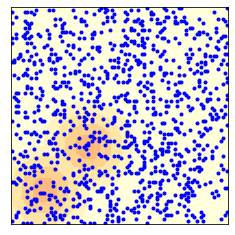

In [214]:
env1 = Sugarscape(100, num_agents=1000)
env1.draw()

Plotting graphs of CDF vs (Vison, Metabolism & Sugar) respectively.

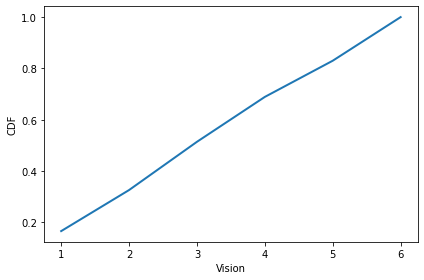

In [184]:
from empiricaldist import Cdf

cdf = Cdf.from_seq(agent.vision for agent in env1.agents)
cdf.plot()
decorate(xlabel = 'Vision', ylabel = 'CDF')

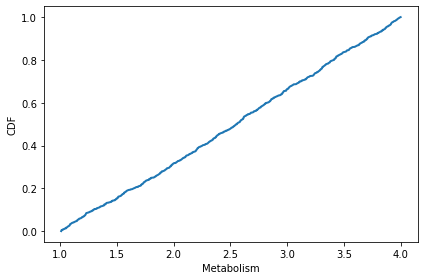

In [131]:
cdf = Cdf.from_seq(agent.metabolism for agent in env1.agents)
cdf.plot()
decorate(xlabel = 'Metabolism', ylabel = 'CDF')

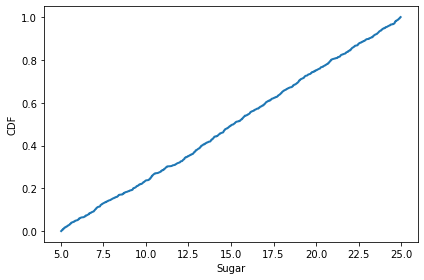

In [132]:
cdf = Cdf.from_seq(agent.sugar for agent in env1.agents)
cdf.plot()
decorate(xlabel = 'Sugar', ylabel = 'CDF')

The agents reach equilibrium or they level off at their carrying capacity with agents = 194

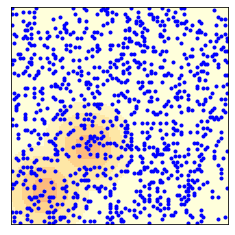

In [215]:
env1.step()
env1.draw()

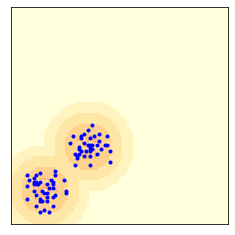

In [216]:
env1.animate(frames = 100)

In [217]:
len(env1.agents)

80

A plot of Number of Agents Vs Time Steps to show that once the population falls it never recovers.

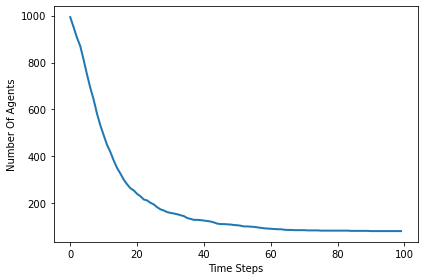

In [218]:
plt.plot(env1.agent_count_seq)
decorate(xlabel = 'Time Steps', ylabel = 'Number Of Agents')

Second Version Of SugarScape (Once an agent dies, it is replaced and hence the population is constant).

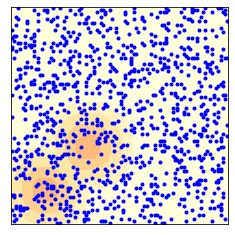

In [137]:
env2 = Sugarscape (100, num_agents = 1000, min_lifespan = 60, max_lifespan = 100, replace = True)
env2.draw()

Plotting graphs of CDF vs (Vison, Metabolism & Sugar) respectively.

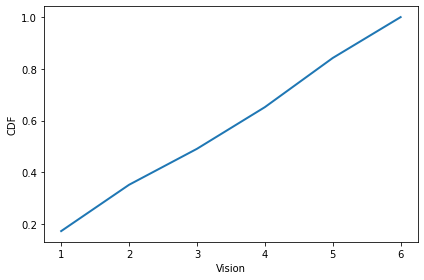

In [138]:
from empiricaldist import Cdf

cdf = Cdf.from_seq(agent.vision for agent in env2.agents)
cdf.plot()
decorate(xlabel = 'Vision', ylabel = 'CDF')

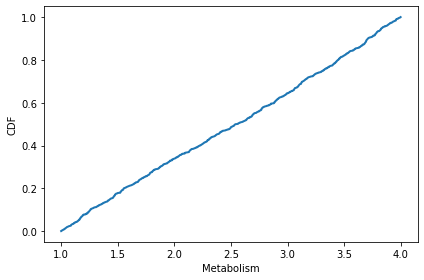

In [139]:
cdf = Cdf.from_seq(agent.metabolism for agent in env2.agents)
cdf.plot()
decorate(xlabel = 'Metabolism', ylabel = 'CDF')

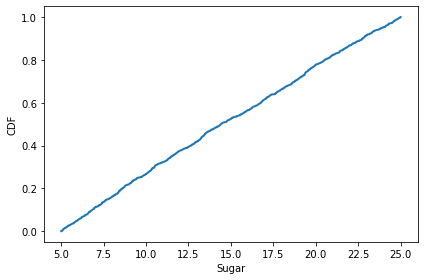

In [140]:
cdf = Cdf.from_seq(agent.sugar for agent in env2.agents)
cdf.plot()
decorate(xlabel = 'Sugar', ylabel = 'CDF')

The agents reach equilibrium or they level off at their carrying capacity with agents = 1000 which is constant as we defined earlier i.e. as an agent dies it is replaced by another agent.

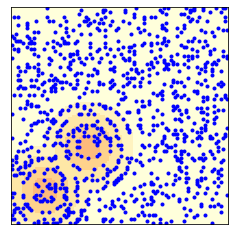

In [141]:
env2.step()
env2.draw()

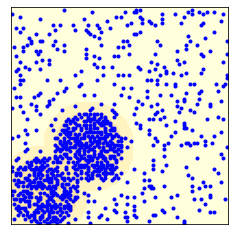

In [143]:
env2.animate(frames = 100)

In [145]:
len(env2.agents)

1000

A plot of Number of Agents Vs Time Steps to show that population is constant throughout.

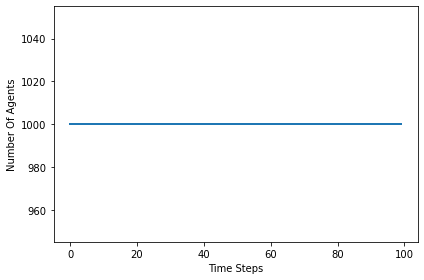

In [146]:
plt.plot(env2.agent_count_seq)
decorate(xlabel = 'Time Steps', ylabel = 'Number Of Agents')

Third Version of Sugarscape i.e. simulation with 'Population Pressure' i.e. adding a new agent at the end of every step.

In [220]:
class third_version_sugar(Sugarscape):

    
    def __init__(self, n, **params):
    
        Sugarscape.__init__(self, n, **params)
        self.avg_vision_seq = []
        self.avg_metabolism_seq = []
    
    def step(self):
        
        Sugarscape.step(self)
        avg_vision = np.mean([agent.vision for agent in self.agents])
        self.avg_vision_seq.append(avg_vision)
        avg_metabolism = np.mean([agent.metabolism for agent in self.agents])
        self.avg_metabolism_seq.append(avg_metabolism)
        
        add_agents = self.params.get('add_agents', False)
        if add_agents:
            self.add_agent()
        
        return len(self.agents)

Running the first version of Sugarscape with n = 1000 on a 100 x 100 grid and then producing graphs of average metabolism, average vision and average population for comparison.

In [221]:
np.random.seed(17)

env3_Sugar_1 = third_version_sugar(100, num_agents=1000)
env3_Sugar_1.loop(1000)

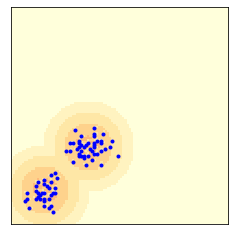

In [222]:
env3_Sugar_1.step()
env3_Sugar_1.draw()

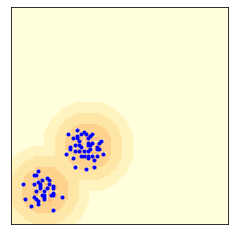

In [223]:
env3_Sugar_1.animate(frames = 100)

In [159]:
len(env3_Sugar_1.agents)

179

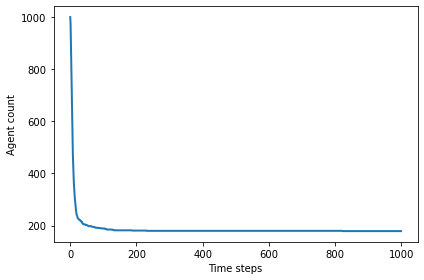

In [149]:
plt.plot(env3_Sugar_1.agent_count_seq)
decorate(xlabel='Time steps', ylabel='Agent count')

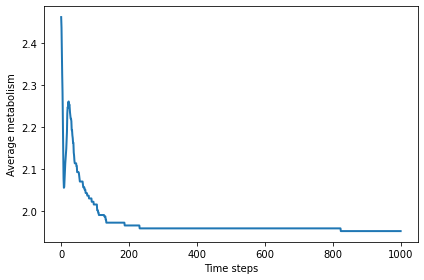

In [150]:
plt.plot(env3_Sugar_1.avg_metabolism_seq)
decorate(xlabel='Time steps', ylabel='Average metabolism')

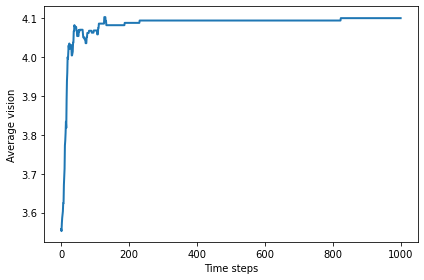

In [151]:
plt.plot(env3_Sugar_1.avg_vision_seq)
decorate(xlabel='Time steps', ylabel='Average vision')

Running the modified version of Sugarscape with n = 1000 on a 100 x 100 grid and then producing graphs of average metabolism, average vision and average population for comparison.

In [224]:
np.random.seed(17)

env3_Sugar_2 = third_version_sugar(100, num_agents = 1000, add_agents = True)
env3_Sugar_2.loop(1000)

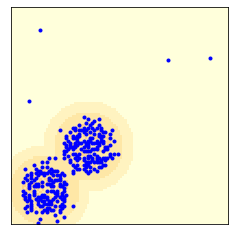

In [160]:
env3_Sugar_2.step()
env3_Sugar_2.draw()

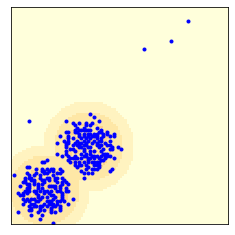

In [161]:
env3_Sugar_2.animate(frames = 100)

In [162]:
len(env3_Sugar_2.agents)

334

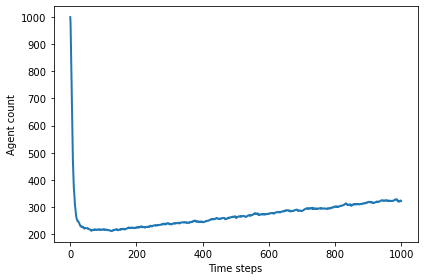

In [154]:
plt.plot(env3_Sugar_2.agent_count_seq)
decorate(xlabel='Time steps', ylabel='Agent count')

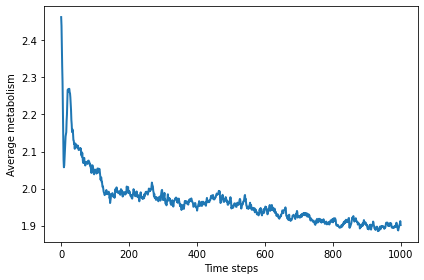

In [155]:
plt.plot(env3_Sugar_2.avg_metabolism_seq)
decorate(xlabel='Time steps', ylabel='Average metabolism')

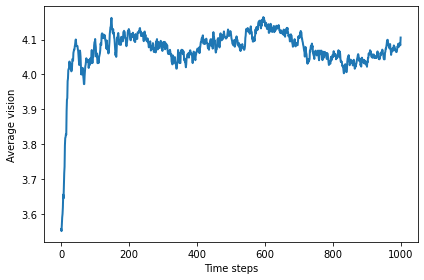

In [156]:
plt.plot(env3_Sugar_2.avg_vision_seq)
decorate(xlabel='Time steps', ylabel='Average vision')